In [2]:
# librerias

import numpy as np

import pandas as pd  # dataframe
import geopandas as gpd

import xarray as xr
import rioxarray as rio
import pylab as plt   # graficos

# prediccion
# from fbprophet import Prophet

import warnings
warnings.filterwarnings('ignore')

## Nivel del mar

In [47]:
import cdsapi
import yaml
 
with open('C:/Users/Irene Aguerri/.cdsapirc', 'r') as f:
        credentials = yaml.safe_load(f)

c = cdsapi.Client(url=credentials['url'], key=credentials['key'])
 
c.retrieve(
    'sis-water-level-change-timeseries-cmip6',
    {
        'format': 'zip',
        'variable': 'mean_sea_level',
        'experiment': 'historical',
        'temporal_aggregation': 'annual',
        'year': [
            '1950', '1951', '1952',
            '1953', '1954', '1955',
            '1956', '1957', '1958',
            '1959', '1960', '1961',
            '1962', '1963', '1964',
            '1965', '1966', '1967',
            '1968', '1969', '1970',
            '1971', '1972', '1973',
            '1974', '1975', '1976',
            '1977', '1978', '1979',
            '1980', '1981', '1982',
            '1983', '1984', '1985',
            '1986', '1987', '1988',
            '1989', '1990', '1991',
            '1992', '1993', '1994',
            '1995', '1996', '1997',
            '1998', '1999', '2000',
            '2001', '2002', '2003',
            '2004', '2005', '2006',
            '2007', '2008', '2009',
            '2010', '2011', '2012',
            '2013', '2014',
        ],
    },
    'sis-water-level-change-timeseries-cmip6_historical.zip')

2022-07-21 17:24:53,082 INFO Welcome to the CDS
2022-07-21 17:24:53,083 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/sis-water-level-change-timeseries-cmip6
2022-07-21 17:24:53,336 INFO Request is queued
2022-07-21 17:24:54,432 INFO Request is running
2022-07-21 17:24:56,007 INFO Request is completed
2022-07-21 17:24:56,007 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data4/dataset-sis-water-level-change-timeseries-cmip6-b4243697-3fef-478a-998f-54c8995f09cb.zip to sis-water-level-change-timeseries-cmip6_historical.zip (20M)
2022-07-21 17:25:03,594 INFO Download rate 2.6M/s                                                                      


Result(content_length=20938147,content_type=application/zip,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data4/dataset-sis-water-level-change-timeseries-cmip6-b4243697-3fef-478a-998f-54c8995f09cb.zip)

In [270]:
dataset = rio.open_rasterio('data/sis-water-level-change-timeseries-cmip6_historical/historical_msl_1950_01_v1.nc')

In [3]:
datasets = xr.open_mfdataset('data/sis-water-level-change-timeseries-cmip6_historical/*.nc', engine='netcdf4',combine="by_coords")

### Pasar a dataset  y a gdf. Low performance

In [127]:
df_tmean = datasets.mean_sea_level.to_dataframe()

In [128]:
df_tmean.head()

station_x_coordinate  station_y_coordinate  \
stations time                                                     
0        1950-01-01                24.089                34.827   
         1951-01-01                24.089                34.827   
         1952-01-01                24.089                34.827   
         1953-01-01                24.089                34.827   
         1954-01-01                24.089                34.827   

                     mean_sea_level  
stations time                        
0        1950-01-01          -0.057  
         1951-01-01          -0.056  
         1952-01-01          -0.055  
         1953-01-01          -0.053  
         1954-01-01          -0.052

In [129]:
df_tmean = df_tmean.reset_index(level='time')

In [130]:
df_tmean['time']=df_tmean['time'].apply(lambda x: int(str(x).split('-')[0]))

In [132]:
df_tmean.head()

,time,station_x_coordinate,station_y_coordinate,mean_sea_level
stations,,,,
0,1950,24.089,34.827,-0.057
0,1951,24.089,34.827,-0.056
0,1952,24.089,34.827,-0.055
0,1953,24.089,34.827,-0.053
0,1954,24.089,34.827,-0.052


In [133]:
df_tmean.rename(columns = {'station_x_coordinate':'longitude', 'station_y_coordinate':'latitude'}, inplace = True)

In [142]:
year_1950 = df_tmean[df_tmean.time== 1950]

In [145]:
year_1950.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 43119 entries, 0 to 43733
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   time            43119 non-null  int64  
 1   longitude       43119 non-null  object 
 2   latitude        43119 non-null  float64
 3   mean_sea_level  43119 non-null  float32
dtypes: float32(1), float64(1), int64(1), object(1)
memory usage: 1.5+ MB


In [144]:
year_1950['longitude'] = year_1950['longitude'].apply(lambda x: format(float(x),".2f"))

In [146]:
year_1950['latitude'] = year_1950['latitude'].apply(lambda x: format(float(x),".2f"))

In [272]:
year_1950['mean_sea_level'] = year_1950['mean_sea_level'].apply(lambda x: format(float(x),".2f"))

In [275]:
year_1950['mean_sea_level'] = year_1950.mean_sea_level.astype(float)

In [148]:
year_1950['latitude'] = year_1950.latitude.astype(float)

In [149]:
year_1950['longitude'] = year_1950.longitude.astype(float)

In [91]:
arr_2d = np.zeros((36000, 18000), dtype= np.float16)

In [153]:
year_1950['lon100'] = year_1950['longitude'] * 100

In [154]:
year_1950['lat100'] = year_1950['latitude'] * 100

In [172]:
year_1950['lon100'] = year_1950.lon100.astype(int)
year_1950['lat100'] = year_1950.lat100.astype(int)

In [266]:
year_1950.shape

(43119, 6)

In [248]:
%debug

> c:\users\irene aguerri\appdata\local\temp\ipykernel_35308\1322804619.py(1)<cell line: 1>()

ipdb> arr2d
array([False])
ipdb> e
Pandas(time=1950, longitude=37.95, latitude=-46.63, mean_sea_level=-0.0729999989271164, lon100=3795, lat100=-4663)
ipdb> e.lat100
-4663
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


In [280]:
for e  in year_1950.itertuples():
#     print(e.mean_sea_level)
    arr2d = arr_2d[[e.lat100],[e.lon100]] == [e.mean_sea_level]
#     arr_2d[[e.lat100],[e.lon100] == e.mean_sea_level

In [264]:
for e in year_1950.itertuples():
    for i in range()
#     print(type(e.lat100))
        arr_2d[e][e.lat100],[e.lon100] = [e][e.mean_sea_level]
#     arr_2d[[e.lat100],[e.lon100] == e.mean_sea_level

AttributeError: 'map' object has no attribute 'shape'

In [281]:
arr_2d[2421][3553]

0.0

In [21]:
import cartopy.crs as ccrs
import numpy as np

import matplotlib.pyplot as plt

proj = ccrs.PlateCarree()

In [31]:
figsize = (10, 5)

zoom = 1

lon_min = year_1950.longitude.min()
lon_max = year_1950.longitude.max()
lat_min = year_1950.latitude.min()
lat_max = year_1950.latitude.max()

extent = [
    lon_min - zoom * 0.5,
    lon_max + zoom * 0.5,
    lat_min - zoom * 0.5,
    lat_max + zoom * 0.5,
]

resolution = "10m"

In [32]:
def default_map(axes=None, global_map=False, background=True):
    if axes is None:
        fig, ax = plt.subplots(figsize=figsize, subplot_kw={"projection": proj})
    else:
        ax = axes

    if global_map:
        ax.set_global()
    else:
        ax.set_extent(extent)

    ax.coastlines(resolution=resolution)

    if background:
        ax.stock_img()

    return ax

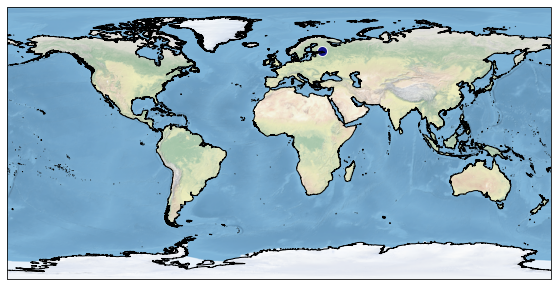

In [33]:
ax = default_map(global_map=True)

plt.scatter(
    year_1950.longitude[4567],
    year_1950.latitude[4567],
    c="navy",
    s=100,
    marker="o",
    edgecolors="white",
    alpha=0.9,
)

plt.show()

In [14]:
import dask

In [15]:
from dask.dataframe import from_pandas

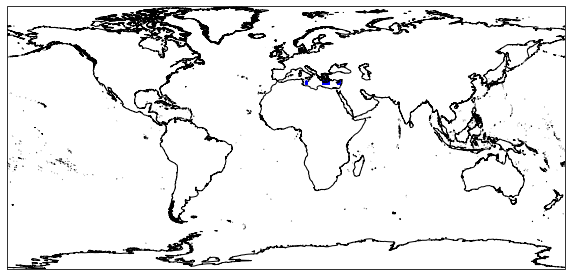

In [36]:
# ddf = from_pandas(year_1950, npartitions = 1)

ax = default_map(background=False)

# lons, lats = np.meshgrid(year_1950.longitude[0:100], year_1950.latitude[0:100])

plt.scatter(lons, lats, c="blue", s=1)

plt.show()

In [ ]:
ax = default_map(background=False)
plt.scatter(lons, lats, c="blue", s=1)

plt.show()

In [ ]:
## crear matriz con valores 